In [74]:
import generax as gx
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
# from generax.training.trainer import Trainer
import generax.util as util
from functools import partial

from typing import Optional, Mapping, Tuple, List, Sequence, Union, Any, Callable, Dict, Iterator, Annotated
from jaxtyping import Array, PRNGKeyArray, PyTree, Scalar, Float
import equinox as eqx
import jax.tree_util as jtu

In [75]:
import svd
jax.config.update("jax_enable_x64", True)

In [76]:
dim = 3
key = random.PRNGKey(0)


class Tensor(eqx.Module):
  values: Array
  gradients: Annotated[Array, '... dim'] # Has an extra dimension at the end

  def __getitem__(self, idx: Any):
    v = self.values[idx]
    g_idx = idx if isinstance(idx, tuple) else (idx,)
    g = self.gradients[g_idx + (slice(None),)]
    return Tensor(v, g)

def make_frame_commuting(frame_tensor: Tensor) -> Tensor:
  # frame: columns are frame vectors E_j in x-coordinates, shape (n, n)
  frame = frame_tensor.values
  # dframe_dx[i, j, r] = ∂(E_j)^i / ∂x^r, shape (n, n, n)
  dframe_dx = frame_tensor.gradients

  # Change basis for derivatives from x to frame directions z:
  # ∂/∂z^k = E_k^r ∂/∂x^r  ⇒  ∂E_j/∂z^k = ∑_r ∂E_j/∂x^r · E_rk
  dframe_dz = jnp.einsum('ijr,rk->ijk', dframe_dx, frame)

  # Frobenius integrability: enforce ∂E_j/∂z^k = ∂E_k/∂z^j by symmetrizing (j,k)
  dframe_dz_sym = 0.5 * (dframe_dz + jnp.swapaxes(dframe_dz, 1, 2))

  # Map derivatives back to x using E^{-1}:
  # ∂E_j/∂x^r = ∑_k ∂E_j/∂z^k · (E^{-1})_kr
  frame_inv = jnp.linalg.inv(frame)
  dframe_dx_new = jnp.einsum('ijk,kr->ijr', dframe_dz_sym, frame_inv)

  return Tensor(frame, dframe_dx_new)

def divergence(A: Tensor):
  return A.gradients.sum(axis=(0, -1)) # Sum the first and last dimensions

def safe_jvp(
  f: Callable,
  A: Float[Array, 'dim dim'],
  dAdx: Annotated[Array, 'dim dim dim']
) -> Tuple[Array, Array]:
  def unbatched_jvp(A, dA):
    return eqx.filter_jvp(f, (A,), (dA,))
  fA, dfA = jax.vmap(unbatched_jvp, in_axes=(None, 0))(A, dAdx)
  fA = jtu.tree_map(lambda x: x[0], fA)
  return fA, dfA

def tensor_decorator(f: Callable):
  def wrapped(A: Tensor):
    A, dAdx = safe_jvp(f, A.values, A.gradients)
    return jtu.tree_map(lambda a, da: Tensor(a, da), A, dAdx)
  return wrapped



def random_tensor(key: PRNGKeyArray, shape: Tuple[int, ...]):
  k1, k2 = random.split(key, 2)
  values = random.normal(k1, shape)
  gradients = random.normal(k2, shape + (dim,))
  return Tensor(values, gradients)

key = random.PRNGKey(0)
k1, k2 = random.split(key, 2)
A = random_tensor(k1, (dim, dim))
B = random_tensor(k2, (dim, dim))

In [77]:
def to_oct(A):
  U, S, V = svd.my_svd(A)
  return U@jnp.diag(S)

A = tensor_decorator(to_oct)(A)
J = make_frame_commuting(A)
U, S, V = tensor_decorator(svd.my_svd)(J)
logS = tensor_decorator(jnp.log)(S)

In [85]:
jnp.einsum("ij,j->ij", U.values, S.values)

Array([[-1.40353821,  1.48433447, -0.03298376],
       [-2.0924461 , -0.49714115,  0.21542352],
       [ 1.6442285 ,  0.63438816,  0.24599265]], dtype=float64)

In [84]:
U.values@jnp.diag(S.values)

Array([[-1.40353821,  1.48433447, -0.03298376],
       [-2.0924461 , -0.49714115,  0.21542352],
       [ 1.6442285 ,  0.63438816,  0.24599265]], dtype=float64)

In [78]:
Binv = tensor_decorator(jnp.linalg.inv)(B)
log_det = tensor_decorator(lambda x: jnp.linalg.slogdet(x)[1])(B)

In [79]:
jnp.einsum('ij,jkq->ikq', Binv.values, B.gradients) + jnp.einsum('ijq,jk->ikq', Binv.gradients, B.values)

Array([[[ 21.36442425, -36.06856443, -33.85583378],
        [ -6.94364214,  16.88666458,  14.48432609],
        [  6.21174876,  -9.29205728,  -8.57467602]],

       [[-10.23540075,  32.43785822,  26.73908711],
        [  1.20706818, -11.41041561,  -8.90684384],
        [ -3.57244657,   8.42474412,   4.89499931]],

       [[ 23.00898614, -72.31040864, -38.1206752 ],
        [-14.57583463,  23.88103857,  14.89359086],
        [  2.03397897, -14.10968362,  -8.91568489]]], dtype=float64)

In [80]:
def blah(B):
  return jnp.linalg.inv(B)@B

In [52]:
log_det.values, log_det.gradients

(Array(-1.01788711, dtype=float64),
 Array([ -7.70451514,   7.22912046, -13.81184274], dtype=float64))

In [58]:
jnp.einsum('ij,jik->k', Binv.values, B.gradients)


Array([-5.4146887 ,  2.89033048, -0.84153296], dtype=float64)

In [7]:
def lie_bracket_values(X, Y):
  return X.gradients@Y.values - Y.gradients@X.values

In [8]:
lie_bracket_values(J[:,0], J[:,1])

Array([-8.88178420e-16,  4.44089210e-16,  1.11022302e-15], dtype=float64)

In [19]:
log_det.values, log_det.gradients

(Array(-0.16149981, dtype=float64),
 Array([  3.        , -10.61490798, -14.43006564], dtype=float64))

In [82]:
def square_norm(A):
  U, S, V = svd.my_svd(A)
  return 0.5*jnp.sum((U[:,0]*S[0])**2)
jax.jvp(square_norm, (A,), (dA,))


(Array(2.08452681, dtype=float64), Array(-3.08283832, dtype=float64))

In [83]:
S[0]**2*dlogS[0]

Array(-3.08283832, dtype=float64)

In [69]:
def sum_of_squares(A):
  U, S, V = svd.my_svd(A)
  q = 1/S.prod()
  return q*0.5*jnp.sum((U@jnp.diag(S))**2, axis=0).sum()

In [70]:
ss, dss = jax.jvp(sum_of_squares, (A,), (dA,))
ss, dss

(Array(10.37719097, dtype=float64), Array(219.11151112, dtype=float64))

In [71]:
def neg_log_likelihood(A):
  U, S, V = svd.my_svd(A)
  q = 1/S.prod()
  return -q*jnp.sum(jnp.log(S))
nll, dnll = jax.jvp(neg_log_likelihood, (A,), (dA,))
nll, dnll

(Array(4.74211069, dtype=float64), Array(188.5697071, dtype=float64))

In [28]:
U[:,1]@dU[:,2]

Array(-0.54406062, dtype=float64)

In [29]:
U[:,1]@dU[:,1]

Array(-1.38777878e-16, dtype=float64)

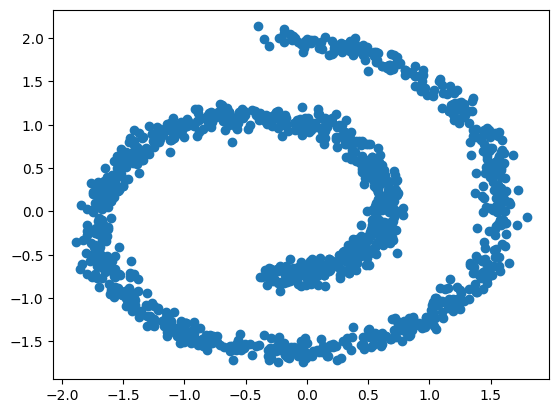

In [57]:
# Get the dataset
from sklearn.datasets import make_moons, make_swiss_roll
data, y = make_swiss_roll(n_samples=100000, noise=0.5)
data = data[:, [0, 2]]
data = data - data.mean(axis=0)
data = data/data.std(axis=0)
key = random.PRNGKey(0)

def get_train_ds(key, batch_size: int = 128):
  total_choices = jnp.arange(data.shape[0])
  closed_over_data = data # In case we change the variable "data"
  while True:
    key, _ = random.split(key, 2)
    idx = random.choice(key,
                        total_choices,
                        shape=(batch_size,),
                        replace=True)
    yield dict(x=closed_over_data[idx])

train_ds = get_train_ds(key)

true_samples = util.extract_multiple_batches_from_iterator(train_ds,
                                                   n_batches=10,
                                                   single_batch=True)
plt.scatter(*true_samples['x'].T)

In [58]:
x = data[:10]

from generax.distributions.flow_models import RealNVP, NeuralSpline, ContinuousNormalizingFlow

model = ContinuousNormalizingFlow(input_shape=x.shape[1:],
                                  key=key,
                                  n_blocks=5,
                                  hidden_size=32,
                                  working_size=16,
                                  time_embedding_size=32,
                                  n_time_features=4*32,
                                  controller_atol=1e-7,
                                  controller_rtol=1e-7)

In [59]:
from generax.training import FlowMatching
import optax

# Create the optimizer
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0,
                                   peak_value=1.0,
                                   warmup_steps=1000,
                                   decay_steps=3e5,
                                   end_value=0.1,
                                   exponent=1.0)
chain = []
chain.append(optax.clip_by_global_norm(15.0))
chain.append(optax.adamw(1e-3))
chain.append(optax.scale_by_schedule(schedule))
optimizer = optax.chain(*chain)

# Create the loss function
fm = FlowMatching(path_type='straight',
                  coupling_type='ot')

# Data dependent initialization for the vector field
data = next(train_ds)
model = fm.initialize_vector_field(model, data, key)

# Create the trainer
trainer = Trainer(checkpoint_path='tmp/flow_matching')
model = trainer.train(model=model,
                      objective=fm.loss_function,
                      evaluate_model=lambda x: x,
                      optimizer=optimizer,
                      num_steps=20000,
                      double_batch=1000,
                      data_iterator=train_ds,
                      checkpoint_every=1000,
                      test_every=-1,
                      retrain=False)

loss: 0.1275:  10%|█         | 2000/20000 [00:36<05:25, 55.23it/s]

Checkpointed model


loss: 0.1218:  15%|█▌        | 3000/20000 [00:49<04:27, 63.47it/s]

Checkpointed model


loss: 0.1207:  20%|██        | 4000/20000 [01:02<03:53, 68.61it/s]

Checkpointed model


loss: 0.1211:  25%|██▌       | 5000/20000 [01:15<03:30, 71.40it/s]

Checkpointed model


loss: 0.1191:  30%|███       | 6000/20000 [01:27<03:09, 73.76it/s]

Checkpointed model


loss: 0.1199:  35%|███▌      | 7000/20000 [01:40<02:52, 75.21it/s]

Checkpointed model


loss: 0.1184:  40%|████      | 8000/20000 [01:53<02:37, 75.99it/s]

Checkpointed model


loss: 0.1196:  45%|████▌     | 9008/20000 [02:06<02:24, 75.86it/s]

Checkpointed model


loss: 0.1182:  50%|█████     | 10008/20000 [02:19<02:11, 76.23it/s]

Checkpointed model


loss: 0.1181:  55%|█████▌    | 11008/20000 [02:31<01:55, 77.96it/s]

Checkpointed model


loss: 0.1196:  60%|██████    | 12008/20000 [02:43<01:40, 79.21it/s]

Checkpointed model


loss: 0.1188:  65%|██████▌   | 13008/20000 [02:56<01:27, 80.02it/s]

Checkpointed model


loss: 0.1179:  70%|███████   | 14008/20000 [03:08<01:14, 80.44it/s]

Checkpointed model


loss: 0.1170:  75%|███████▌  | 15008/20000 [03:20<01:01, 80.78it/s]

Checkpointed model


loss: 0.1177:  80%|████████  | 16008/20000 [03:32<00:49, 81.11it/s]

Checkpointed model


loss: 0.1153:  85%|████████▌ | 17008/20000 [03:45<00:36, 81.49it/s]

Checkpointed model


loss: 0.1169:  90%|█████████ | 18008/20000 [03:57<00:24, 81.70it/s]

Checkpointed model


loss: 0.1171:  95%|█████████▌| 19008/20000 [04:09<00:12, 81.86it/s]

Checkpointed model


loss: 0.1174:   0%|          | 20/20000 [04:21<72:33:33, 13.07s/it]

Checkpointed model


In [60]:
samples = model.sample(key, n_samples=1000)

In [70]:
T = 5
ts = jnp.linspace(0.0, 1.0, T)

def get_time_samples(z):
  log_pz = model.prior.log_prob(z)
  x, log_det = model.transform.neural_ode(z,
                                    inverse=True,
                                    log_likelihood=True,
                                    save_at=ts)
  log_px = log_pz - log_det
  return x, log_px

z = random.normal(key, (10000, 2))
samples, log_px = jax.vmap(get_time_samples)(z)
samples.shape

(10000, 5, 2)

In [71]:
log_px.shape

(10000, 5)

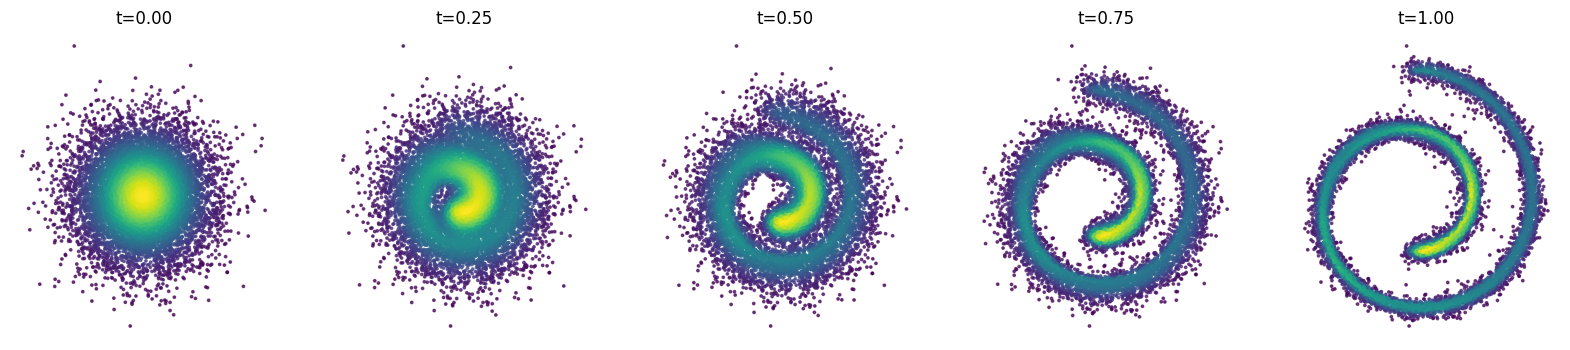

In [73]:
n_rows, n_cols = 1, T
size = 4
fig, axes = plt.subplots(1, T, figsize=(n_cols*size, n_rows*size))
ax_iter = iter(axes.ravel())
for i, t in enumerate(ts):
  ax = next(ax_iter)
  ax.scatter(*samples[:, i].T, alpha=0.7, s=3, c=jnp.exp(log_px)[:, i])
  ax.set_title(f't={t:3.2f}')
  ax.set_axis_off()

import os
# Get the path for ~
home = os.path.expanduser("~")
save_dir = os.path.join(home, 'eddiecunningham.github.io', 'content', 'images')
save_path = os.path.join(save_dir, 'cnf_evolution.png')
plt.savefig(save_path, bbox_inches='tight')